In [4]:
from PIL import Image
from argparse import Namespace
import numpy as np
import glob
import utils
import skimage.metrics
import pyheif
import os
from matplotlib import pyplot as plt 

def encode_jpeg(raw_name):
    im = Image.open(raw_name)
    for q in [35, 50, 75, 95]:
        jpg_name = utils.make_filepath(raw_name, dir_name=args.output, ext_name='jpg', tag=f'{q}-jpeg')
        print(f'save {jpg_name}')
        im.save(jpg_name, quality=q)

def encode_webp(raw_name):
    im = Image.open(raw_name)
    for q in [35, 50, 75, 95]:
        jpg_name = utils.make_filepath(raw_name, dir_name=args.output, ext_name='webp', tag=f'{q}-webp')
        print(f'save {jpg_name}')
        im.save(jpg_name, quality=q)

def encode_heif(raw_name):
    im = Image.open(raw_name)
    for q in [35, 50, 75, 95]:
        jpg_name = utils.make_filepath(raw_name, dir_name=args.output, ext_name='heic', tag=f'{q}-heif')
        print(f'save {jpg_name}')
        utils.run_cmd(f'heif-enc -q {q} -o {jpg_name} {raw_name} -b 8')

def encode_jpeg2000(raw_name):
    im = Image.open(raw_name)
    qlayer = { 35: 34, 50: 35, 75: 37, 95: 42}
    rlayer = { 35: 25, 50: 20, 75: 12, 95: 8}
    for q in [35, 50, 75, 95]:
        jpg_name = utils.make_filepath(raw_name, dir_name=args.output, ext_name='jp2', tag=f'{q}-jpeg2000')
        print(f'save {jpg_name}')
        utils.run_cmd(f'grk_compress -i {raw_name} -o {jpg_name} -r {rlayer[q]}')
        #utils.run_cmd(f'grk_compress -i {raw_name} -o {jpg_name} -q {qlayer[q]}')

do_encode = {
    'jpeg': encode_jpeg,
    'jpeg2000': encode_jpeg2000,
    'webp': encode_webp,
    'heif': encode_heif,
}

def exec_encode(args):
    for im_name in args.images:
        for codec in do_encode.keys():
            do_encode[codec](im_name)

def read_heic(name):
    heif_file = pyheif.read(name)
    image = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
    return image
            
def exec_perf(args):
    jpgs = glob.glob(args.output + f'/*')
    cached_img = {}
    rdc = {}
    for jpg_name in sorted(jpgs):
        jvs = os.path.basename(jpg_name).split('.')[0].split('-')
        ref_base = jvs[0]
        codec = jvs[2]
        ref_name = utils.make_filepath(ref_base, dir_name=args.source, ext_name=args.img_ext)
        if ref_base not in cached_img:
            print(f'load {ref_name}')
            cached_img[ref_base] = np.array(Image.open(ref_name).convert('L'))
            rdc[ref_base] = {}
        if codec not in rdc[ref_base]:
            rdc[ref_base][codec] = { 'bpp': [], 'fsim': [], 'ssim': [], 'psnr': [] }
        ref_img = cached_img[ref_base]
        if os.path.basename(jpg_name).split('.')[1] == 'heic':
            dst_img = np.array(read_heic(jpg_name).convert('L'))
        else:
            dst_img = np.array(Image.open(jpg_name).convert('L'))
        bpp = os.path.getsize(jpg_name) * 8 / (ref_img.shape[0] * ref_img.shape[1] * 3)
        psnr = skimage.metrics.peak_signal_noise_ratio(ref_img, dst_img)
        ssim = skimage.metrics.structural_similarity(ref_img, dst_img, gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
        rdc[ref_base][codec]['bpp'].append(bpp)
        rdc[ref_base][codec]['psnr'].append(psnr)
        rdc[ref_base][codec]['ssim'].append(ssim)
        print(f'{jpg_name:40s}: bpp={bpp:f}, PSNR={psnr:f} SSIM={ssim:f}')
    return rdc


In [5]:
args = { 
    'source': 'images', 'output': 'output', 'img_ext': 'png'
}

args = Namespace(**args)

if args.source is not None:
    args.images = glob.glob(args.source + f'/*.{args.img_ext}')

utils.ensure_dir(args.output)

exec_encode(args)

res = exec_perf(args)

save output/kodim03-35-jpeg.jpg
save output/kodim03-50-jpeg.jpg
save output/kodim03-75-jpeg.jpg
save output/kodim03-95-jpeg.jpg
save output/kodim03-35-jpeg2000.jp2
grk_compress -i images/kodim03.png -o output/kodim03-35-jpeg2000.jp2 -r 25
save output/kodim03-50-jpeg2000.jp2
grk_compress -i images/kodim03.png -o output/kodim03-50-jpeg2000.jp2 -r 20
save output/kodim03-75-jpeg2000.jp2
grk_compress -i images/kodim03.png -o output/kodim03-75-jpeg2000.jp2 -r 12
save output/kodim03-95-jpeg2000.jp2
grk_compress -i images/kodim03.png -o output/kodim03-95-jpeg2000.jp2 -r 8
save output/kodim03-35-webp.webp
save output/kodim03-50-webp.webp
save output/kodim03-75-webp.webp
save output/kodim03-95-webp.webp
save output/kodim03-35-heif.heic
heif-enc -q 35 -o output/kodim03-35-heif.heic images/kodim03.png -b 8
save output/kodim03-50-heif.heic
heif-enc -q 50 -o output/kodim03-50-heif.heic images/kodim03.png -b 8
save output/kodim03-75-heif.heic
heif-enc -q 75 -o output/kodim03-75-heif.heic images/kodim

output/kodim05-35-jpeg2000.jp2          : bpp=0.320068, PSNR=29.978377 SSIM=0.879218
output/kodim05-35-webp.webp             : bpp=0.430339, PSNR=31.584726 SSIM=0.918175
output/kodim05-50-heif.heic             : bpp=0.547377, PSNR=37.916638 SSIM=0.977904
output/kodim05-50-jpeg.jpg              : bpp=0.468940, PSNR=30.730338 SSIM=0.920883
output/kodim05-50-jpeg2000.jp2          : bpp=0.399814, PSNR=31.839279 SSIM=0.920159
output/kodim05-50-webp.webp             : bpp=0.510159, PSNR=33.150007 SSIM=0.938140
output/kodim05-75-heif.heic             : bpp=1.423204, PSNR=47.133758 SSIM=0.997303
output/kodim05-75-jpeg.jpg              : bpp=0.686001, PSNR=33.847177 SSIM=0.956120
output/kodim05-75-jpeg2000.jp2          : bpp=0.666694, PSNR=36.326569 SSIM=0.963410
output/kodim05-75-webp.webp             : bpp=0.644965, PSNR=35.643781 SSIM=0.961403
output/kodim05-95-heif.heic             : bpp=2.308099, PSNR=49.818840 SSIM=0.999083
output/kodim05-95-jpeg.jpg              : bpp=1.535712, PSNR=43.6

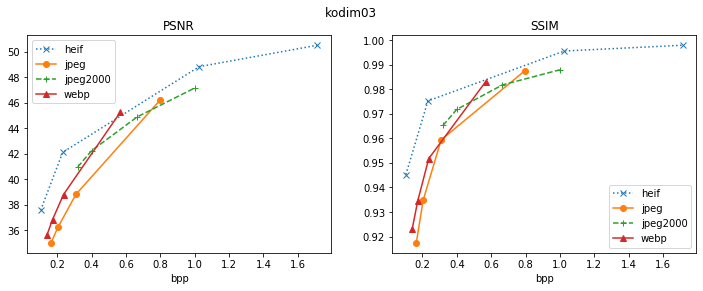

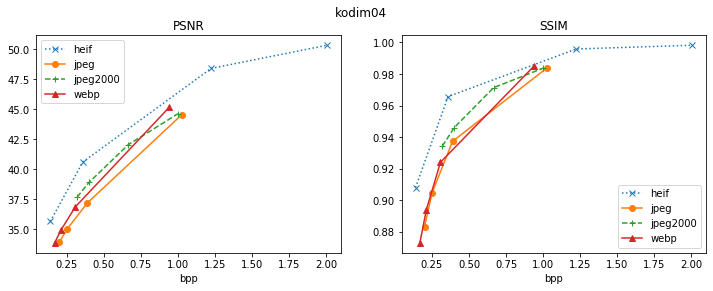

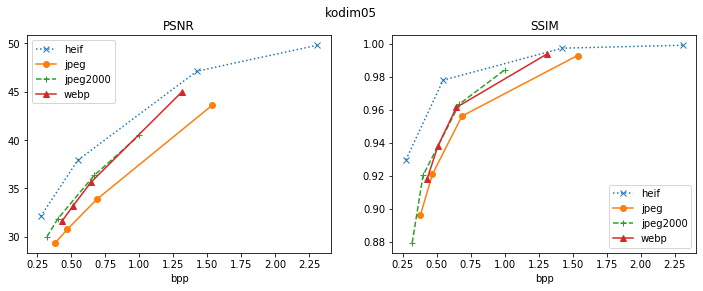

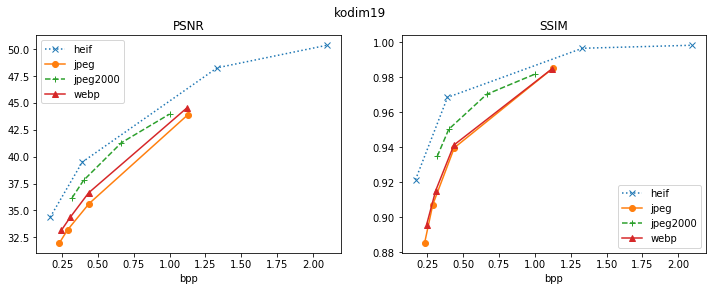

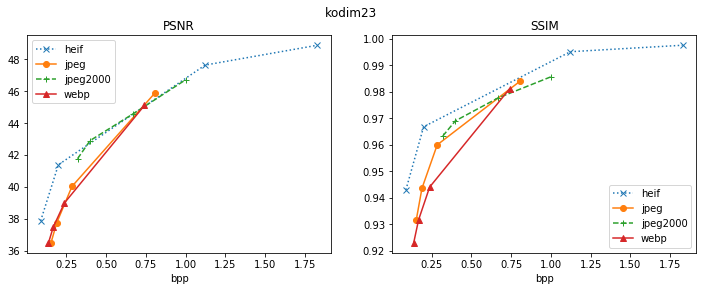

In [6]:
%matplotlib inline

met = ['psnr', 'ssim']
pat = ['x:', 'o-', '+--', '^-']

fnames = list(res.keys())

codec = list(res[fnames[0]].keys())

for f in fnames:
    figure, ax = plt.subplots(1, len(met), figsize=(12,4))
    for i in range(len(met)):
        d_type = met[i]
        for j, c in enumerate(codec):
            mbpp = {}
            plt.suptitle(f)
            for d in range(len(res[f][c]['bpp'])):
                mbpp[res[f][c]['bpp'][d]] = res[f][c][d_type][d]
            x = list(sorted(mbpp.keys()))
            y = [mbpp[b] for b in x]
            ax[i].plot(x, y, pat[j], label=c)

        ax[i].set_xlabel('bpp')
        ax[i].set_title(d_type.upper())
        ax[i].legend()